### Question 2 Baseline Batch 
Ahmed Shahzad & Andrew Corum

In [1]:
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np 

X, y = mnist["data"], mnist["target"]
y = y.astype(int)

X = ((X/255.) - .5)*2

print(X.shape, y.shape)
print(min(y), max(y))
print(type(X),type(y))
print(np.min(np.min(X)), np.max(np.max(X)))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


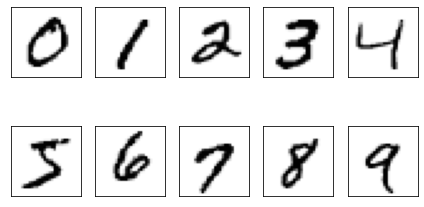

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    matchlist = [i for i, x in enumerate(y == i) if x]
    img =X[matchlist[0]].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
#saving valdiation split for later 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit 
import collections

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in split.split(X_train, y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]
    
    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]
    
print(X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [6]:
#define hyperparatmers 
#these can be any value as a theoery doesn't exist

class hyperparam():
    num_hid1_units = 300
    num_hid2_units = 100
    num_classes = 10
    input_dim = 28 * 28 
    
    lr = 0.01 # learning rate
    num_epochs = 50 #number of epochs 
    bs = 50 #mini_batch size 
    momentum = 0.9 
    

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 
import torch.optim as optim
import torch.utils.data as data 
import random 
from scipy.io import savemat 
import os 
from os import path
from sklearn.preprocessing import normalize 
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel 
from sklearn.metrics import confusion_matrix 

In [8]:

class myDataset(data.Dataset):
    def __init__(self, input_data, labels):
        self.feats = input_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels) #returns the number of samples 
    
    def __getitem__(self, index):
        X = self.feats[index,:]
        y =self.labels[index]
        return X, y

In [9]:
params ={'batch_size': hyperparam.bs, 
        'shuffle': True,
         'num_workers': 0, 
         'drop_last': False, 
         'pin_memory': True}

training_set = myDataset(X_train_strat, y_train_strat)
dev_set = myDataset(X_dev_strat, y_dev_strat)
test_set = myDataset(X_test,y_test)

training_gen = data.DataLoader(training_set, **params)
dev_gen = data.DataLoader(dev_set, **params)
testing_gen = data.DataLoader(test_set,**params)

In [10]:
class BaseLineCNN(torch.nn.Module):
    def __init__(self):
        super(BaseLineCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 12, kernel_size=5, stride=2) #kernel size is the layer 
        self.conv2 = torch.nn.Conv2d(12, 50,kernel_size=5, stride=2)
        #self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(50, 50)
        self.fc2 = torch.nn.Linear(50, 10)
        #GLORATH INTILIZATION 
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.conv1(x)
        fish = torch.nn.BatchNorm2d(12)
        x = fish(x)
        x = F.max_pool2d(x, 2)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        fish = torch.nn.BatchNorm2d(50)
        x = fish(x)
        x = torch.nn.functional.relu(x)
        x = x.view(-1, 50)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [11]:
cnn_Model = BaseLineCNN()
optimizer = torch.optim.SGD(cnn_Model.parameters(), lr=hyperparam.lr, momentum = hyperparam.momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss = nn.CrossEntropyLoss()

### Baseline Batch Model run

In [12]:
tr_avgLoss_list = []
tr_accuracy_list = []
dev_avgLoss_list = []
dev_accuracy_list = []
count = 1 
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples=0
    tr_total_loss = 0.0
    
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    cnn_Model.train(True)
    print("Epoch Number ", count)
    count = count + 1
    print("Currently Training")
    with torch.set_grad_enabled(True):
        for local_batch, local_labels in training_gen:
           
            optimizer.zero_grad()
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            
            out1 = cnn_Model(local_batch.view(local_batch.shape[0],1,28,28))
            
            pLoss = loss(out1,local_labels.long())
            
            tr_total_loss += pLoss * hyperparam.bs
            
            pLoss.backward()
            optimizer.step()
            
            sel_class = torch.argmax(out1, dim=1)
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
            
        tr_avgLoss = tr_total_loss / len(training_gen.dataset)
    
        tr_avgLoss_list.append(tr_avgLoss)
    
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)
    
    print("Currently Testing")
    with torch.set_grad_enabled(False):
        cnn_Model.eval()
        
        for local_batch, local_labels in dev_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            out1 = cnn_Model(local_batch.view(local_batch.shape[0],1,28,28))

            pLoss = loss(out1, local_labels.long())
            dev_total_loss += pLoss * hyperparam.bs

            sel_class = torch.argmax(out1,dim=1)

            dev_num_correct += sel_class.eq(local_labels).sum().item()
            dev_num_samples += hyperparam.bs
    
        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)

        dev_accuracy = dev_num_correct / dev_num_samples
        dev_accuracy_list.append(dev_accuracy)
    
    scheduler.step()

print("training set: ", tr_accuracy_list)
print("validation list: ", dev_accuracy_list)


Epoch Number  1
Currently Training
Currently Testing
Epoch Number  2
Currently Training
Currently Testing
Epoch Number  3
Currently Training
Currently Testing
Epoch Number  4
Currently Training
Currently Testing
Epoch Number  5
Currently Training
Currently Testing
Epoch Number  6
Currently Training
Currently Testing
Epoch Number  7
Currently Training
Currently Testing
Epoch Number  8
Currently Training
Currently Testing
Epoch Number  9
Currently Training
Currently Testing
Epoch Number  10
Currently Training
Currently Testing
Epoch Number  11
Currently Training
Currently Testing
Epoch Number  12
Currently Training
Currently Testing
Epoch Number  13
Currently Training
Currently Testing
Epoch Number  14
Currently Training
Currently Testing
Epoch Number  15
Currently Training
Currently Testing
Epoch Number  16
Currently Training
Currently Testing
Epoch Number  17
Currently Training
Currently Testing
Epoch Number  18
Currently Training
Currently Testing
Epoch Number  19
Currently Training
C

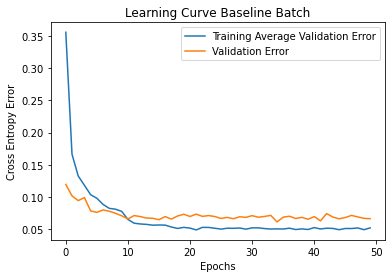

In [13]:
plt.title("Learning Curve Baseline Batch")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Error")
plt.plot(range(50),  tr_avgLoss_list, label="Training Average Validation Error")
plt.plot(range(50), dev_avgLoss_list, label="Validation Error")
plt.legend()
plt.show()

In [14]:
testout = cnn_Model.forward(torch.tensor(X_test).view(X_test.shape[0],1,28,28).float())
class_selected = torch.argmax(testout, dim=1)
right = 0
right += class_selected.eq(torch.tensor(y_test)).sum().item()
acc = right / 10000
print("Accuracy for test ", acc*100, "%" )
                            

Accuracy for test  98.76 %


In [15]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix

confusionplot = confusion_matrix(y_test ,class_selected)
print(confusionplot)
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[[ 974    1    1    0    1    0    1    2    0    0]
 [   0 1132    1    0    0    0    0    1    0    1]
 [   1    3 1012    3    1    1    1    9    1    0]
 [   0    0    1 1003    0    3    0    1    2    0]
 [   0    0    0    0  976    0    2    0    0    4]
 [   1    0    0    4    0  882    2    2    1    0]
 [   3    2    1    0    2    2  946    0    2    0]
 [   1    4    9    1    0    0    0 1012    0    1]
 [   1    0    3    1    1    2    0    2  961    3]
 [   4    1    0    0   10   11    0    3    2  978]]


### REPORT 
The baseline system two learning curves reasonably fits in the plot. Which means that the CNN performs well with both the training and validation data with an accuracy around 98.76%. This is better than the baseline which was at 98.61% but it seems non signifcant considering both baseline are within the same ball park. This did better in regards to the dropouts however. Please note by accuracy I'm refering to the testing accuracy